## Tutorial 1: simulate datasets        

- ### Import packages

In [1]:
import torch
import scipy.sparse as sp
import scanpy as sc
from spatialign import Spatialign
from warnings import filterwarnings
from anndata import AnnData

filterwarnings("ignore")

In [2]:
datasets = [
    "lfdb_simulate1.h5ad",
    "lfdb_simulate2.h5ad",
    "lfdb_simulate3.h5ad"
]

In [3]:
def pca_lowrank(data, n_component=50, use_rep=None):
    data.uns["pca"] = {}
    if use_rep is None:
        x_tensor = torch.tensor(data.X.toarray()) if sp.issparse(data.X) else torch.tensor(data.X)
    else:
        assert use_rep in data.obsm_keys()
        x_tensor = torch.tensor(data.obsm[use_rep])
    u, s, v = torch.pca_lowrank(x_tensor, q=n_component)

    explained_variance_ = s.pow(2) / (data.shape[0] - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var
    data.obsm["X_pca"] = torch.matmul(x_tensor, v).numpy()
    data.uns["pca"]["variance"] = explained_variance_.numpy()
    data.uns["pca"]['variance_ratio'] = explained_variance_ratio_.numpy()

- ### Initialize              

     Read datasets and load Spatialign model

In [4]:
model = Spatialign(
    *datasets,
    batch_key='batch',
    is_norm_log=True,
    is_scale=False,
    n_neigh=15,
    is_undirected=True,
    latent_dims=100,
    seed=42,
    gpu=0,
    save_path="./",
    is_verbose=False
)

2023-07-21 18:18:18 Found Dataset: 
  cell nums: 4226 gene nums: 1999
  cell nums: 3661 gene nums: 1999
  cell nums: 3639 gene nums: 1999
2023-07-21 18:18:20: Spatial coordinates are used to calculate nearest neighbor graphs
2023-07-21 18:18:24 Method: 'init_bank' Running...
  Running time: 0.0 min 1.1580 s


- ### Visualization original dataset by UMAP

In [5]:
raw_merge = AnnData.concatenate(*model.dataset.data_list)

In [6]:
pca_lowrank(raw_merge, n_component=100)
sc.pp.neighbors(raw_merge, random_state=42)
sc.tl.umap(raw_merge, random_state=42)

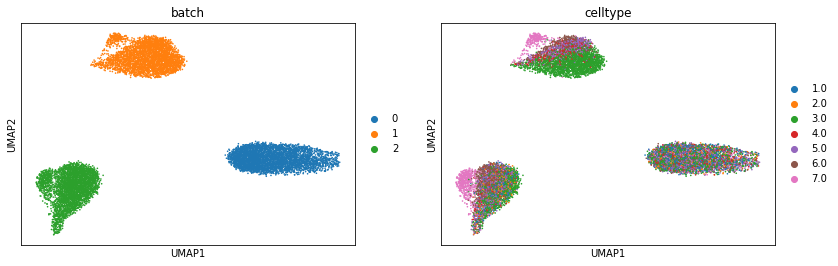

In [7]:
sc.pl.umap(raw_merge, color=["batch", "celltype"])

- ### Training Spatialign model     

     Spatialign aims to aligns the biological effects, while maximized preserving spots/cells biological variances in the latent embedding.        
      
    It is possible to fine-tune the parameters (tau1, tau2, tau3) to optimize the model's performance.

In [ ]:
model.train(tau1=0.05, tau2=0.01, tau3=0.1)

2023-07-21 18:22:57 Method: 'train' Running...
  2023-07-21 18:23:40 Epoch: 115 Loss: 33.5209 Loss min: 33.4969 EarlyStopping counter: 1 out of 155

- ### Inference alignment datasets      
    
     After model training, the learned lower-dimensional representations will be saved in adata.obsm['correct'], and the higher-dimensional representations will be saved in adata.X

In [ ]:
model.alignment()

- ### Validation inference datasets

In [ ]:
correct1 = sc.read_h5ad("./res/correct_data0.h5ad")
correct2 = sc.read_h5ad("./res/correct_data1.h5ad")
correct3 = sc.read_h5ad("./res/correct_data2.h5ad")

In [ ]:
merge_data = correct1.concatenate(correct2, correct3)

In [ ]:
sc.pp.neighbors(merge_data, use_rep="correct", random_state=42)
sc.tl.umap(merge_data, random_state=42)

In [ ]:
sc.pl.umap(merge_data, color=["batch", "celltype"])